In [100]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [66]:
df_btc = pd.read_csv("BTC_1h_data.csv")

In [67]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


In [68]:
df_headers = df_btc.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [69]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [70]:
percTrain = 70
percVal = 20 

In [71]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [72]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [73]:
window_length = 24
features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [74]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [75]:
#Reshaping the data so we can use min-max a
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 24, 1)


<Strong> Creating the model </Strong>

<Strong> Dropout / Desnse layers <Strong>

In [76]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 24, 30)       3840        ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 24, 30)       0           ['lstm_4[0][0]']                 
                                                                                                  
 gru_2 (GRU)                    (None, 30)           2970        ['input_3[0][0]']                
                                                                                            

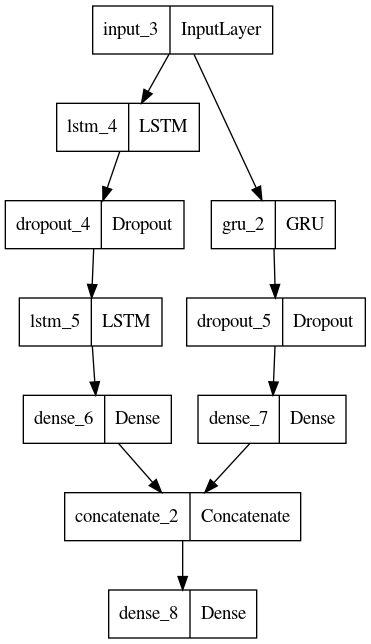

In [77]:
model.summary()
plot_model(model)

In [78]:
#If use validation in this part , then leakage as we are using the normalized values of the training set which in this case would include validation set.
#Validation set needs to be in a tuple with x , y

model.compile(optimizer='adam' , loss = 'mse')

In [79]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

In [80]:
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])



Epoch 1/300
54/54 [==============================] - 5s 26ms/step - loss: 0.0096 - val_loss: 0.1024
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0123e-04 - val_loss: 0.1384
Epoch 3/300
54/54 [==============================] - 0s 9ms/step - loss: 7.9643e-05 - val_loss: 0.1355
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 7.8088e-05 - val_loss: 0.1315
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 7.6098e-05 - val_loss: 0.1263
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 7.6660e-05 - val_loss: 0.1229
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 7.2599e-05 - val_loss: 0.1149
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 7.2703e-05 - val_loss: 0.1132
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 7.1088e-05 - val_loss: 0.1066
Epoch 10/300
54/54 [==============================] - 0s 8ms/step - loss: 6.

In [89]:
num_epochs = earlyStopping.stopped_epoch

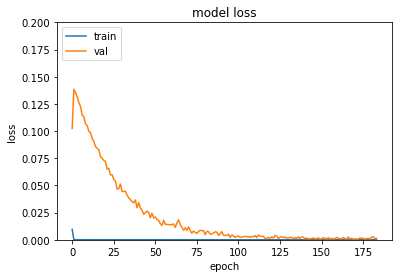

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.2])
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [84]:
validation_predict = model.predict(btc_val[0])

In [85]:
validation_predict = scaler.inverse_transform(validation_predict)

In [86]:
print(validation_predict)

[[10795.956]
 [10794.387]
 [10800.129]
 ...
 [48311.785]
 [48169.67 ]
 [48347.465]]


In [87]:
validation_actual = scaler.inverse_transform(btc_val[1])
validation_actual

array([[10759.79],
       [10765.29],
       [10766.35],
       ...,
       [48674.72],
       [48866.  ],
       [48732.71]])

In [88]:
math.sqrt(mean_squared_error(validation_actual , validation_predict))

607.0071712321869

<Strong> Train on both training and validation , then finnaly test on test set. </Strong>

In [52]:
train_and_val = np.concatenate([btc_train[0] , btc_val[0]] )
train_and_val_targets = np.concatenate([btc_train[1] , btc_val[1] ])

<Strong> Only do this last , once perfected hyper-parameters. <Strong>

In [95]:
freshModel = tf.keras.Model(inputs=inputs, outputs= final)
freshModel.compile(optimizer='adam' , loss = 'mse')

In [96]:
final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/183
69/69 [==============================] - 4s 8ms/step - loss: 6.6416e-04
Epoch 2/183
69/69 [==============================] - 0s 7ms/step - loss: 2.5926e-04
Epoch 3/183
69/69 [==============================] - 1s 7ms/step - loss: 2.4616e-04
Epoch 4/183
69/69 [==============================] - 1s 7ms/step - loss: 2.7054e-04
Epoch 5/183
69/69 [==============================] - 0s 7ms/step - loss: 2.5943e-04
Epoch 6/183
69/69 [==============================] - 0s 7ms/step - loss: 2.3537e-04
Epoch 7/183
69/69 [==============================] - 1s 7ms/step - loss: 2.8968e-04
Epoch 8/183
69/69 [==============================] - 0s 7ms/step - loss: 2.3732e-04
Epoch 9/183
69/69 [==============================] - 0s 7ms/step - loss: 2.3959e-04
Epoch 10/183
69/69 [==============================] - 0s 7ms/step - loss: 2.4756e-04
Epoch 11/183
69/69 [==============================] - 0s 7ms/step - loss: 2.5062e-04
Epoch 12/183
69/69 [==============================] - 0s 7ms/step - loss: 

In [97]:
test_predict = freshModel.predict(btc_test[0])

In [98]:
#Scalling back to the original values 
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(btc_test[1])

In [104]:
math.sqrt(mean_absolute_error(test_actual , test_predict))

17.22390771633541